# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Disable chained assignment warning
import warnings
warnings.simplefilter('ignore', FutureWarning)
pd.options.mode.chained_assignment = None
pd.set_option('future.no_silent_downcasting', True)

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
data_azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('Data structure')
print(f'- Rows: {data_azdias.shape[0]}')
print(f'- Columns: {data_azdias.shape[1]}\n')

data_azdias.head()


Data structure
- Rows: 891221
- Columns: 85



,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
data_azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.

feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
# Get the number of nans in the original data
data_nans_sums = data_azdias.isna().sum().sum()

print(f"- Number of nans in original data: {data_nans_sums} | "
      f"{data_nans_sums/(data_azdias.shape[0]*data_azdias.shape[1])*100:.2f}%")

- Number of nans in original data: 4896838 | 6.46%


In [7]:
# Convert missing values to NaNs.
j = 0
for index, row in feat_info.iterrows():
    j += 1
    att = row['attribute']
    att_type = row['type']
    att_missing_values = row['missing_or_unknown'].replace('[', '').replace(']', '').split(',')

    for i in range(len(att_missing_values)):
        value = att_missing_values[i]
        try:
            value = int(value)
        except:
            value = str(value)
            
        if att_missing_values[i] != '':
            data_azdias.loc[data_azdias[att]==value, att ] = np.nan
            data_azdias[att]==att_missing_values[i]


        

In [8]:
# Get the number of nans in the processed data
data_nans_sums = data_azdias.isna().sum().sum()

print(f"- Number of nans in original data: {data_nans_sums} | "
      f"{data_nans_sums/(data_azdias.shape[0]*data_azdias.shape[1])*100:.2f}%")

- Number of nans in original data: 8373929 | 11.05%


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
nans_by_column = (data_azdias.isna().sum() / len(data_azdias)) * 100

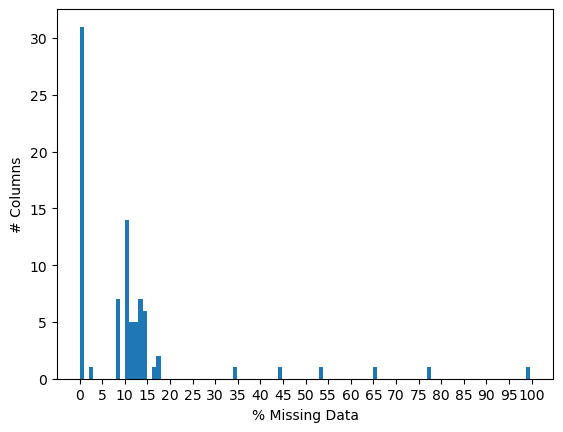

In [10]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(nans_by_column, bins=100);
plt.ylabel('# Columns')
plt.xlabel('% Missing Data')
plt.xticks(range(0,101,5));

In [11]:
nans_by_column[nans_by_column>=15].count()

np.int64(9)

The graph above illustrates the distribution of missing data across the columns in the dataset. We observe that 9 columns have more than 15% of their values missing. Lets take a closer look into these columns to determine how to handle them.

In [12]:
nans_by_column[nans_by_column>=15].sort_values()

W_KEIT_KIND_HH    16.605084
KKK               17.735668
REGIOTYP          17.735668
ALTER_HH          34.813699
GEBURTSJAHR       44.020282
KBA05_BAUMAX      53.468668
KK_KUNDENTYP      65.596749
AGER_TYP          76.955435
TITEL_KZ          99.757636
dtype: float64

In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Create a list with columns that have more than 15% of missing values
# We decided to keep W_KEIT_KIND_HH with 16.60% of missing values
columns_drop = ['KKK', 'REGIOTYP', 'ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 
                'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ']

for column in columns_drop:
    data_azdias = data_azdias.drop(column, axis=1)

In [14]:
data_azdias.shape

(891221, 77)

In [15]:
# Get the number of nans in the data after dropping columns with > 15% missing values
data_nans_sums = data_azdias.isna().sum().sum()

print(f"- Number of nans in cleaned data: {data_nans_sums} | "
      f"{data_nans_sums/(data_azdias.shape[0]*data_azdias.shape[1])*100:.2f}%")

- Number of nans in cleaned data: 4719176 | 6.88%


In [16]:
nans_by_column = (data_azdias.isna().sum() / len(data_azdias)) * 100
nans_by_column[nans_by_column>=15].sort_values()

W_KEIT_KIND_HH    16.605084
dtype: float64

#### Discussion 1.1.2: Assess Missing Data in Each Column

The following columns had more than 15% of missing values:

- W_KEIT_KIND_HH (Likelihood of children in household): 16.60%
- KKK (Purchasing power in region): 17.73%
- REGIOTYP (Neighborhood typology): 17.73%
- ALTER_HH (Birthdate of head of household): 35%
- GEBURTSJAHR (Year of birth): 44%
- KBA05_BAUMAX (Most common type of building in microcell): 53%
- KK_KUNDENTYP (Consumer patter over las 12 months): 66%
- AGER_TYP (Typology of elder people): 77%
- TITEL_KZ (Type of academic title): 100%

After examining the dictionary, we decided to retain *W_KEIT_KIND_HH* and remove the others. The reasons are outlined below:

*W_KEIT_KIND_HH*: This column represents the likelihood of children in the household, which can greatly influence purchasing habits. Because of this, despite having 16.60% missing values, we decided to keep it.

*KKK*: Although this columns provides information about the purchasing power in the region, there are other columns that can offer similar information, like LP_STATUS_GROB (Socioeconomic status) and LP_FAMILIE_FEIN (Detailed family typology).

*REGIOTYP*: The typology of the neighboorhood could help us determine spending habits, but other columns like LP_LEBENSPHASE_FEIN (Detailed life phase typology) and LP_LEBENSPHASE_GROB (Coarse life phase typology) can supplement this data.

*ALTER_HH*: This field gives us information about the age of the head of the household, which could have an influence in the purchasing behaviour. However, PRAEGENDE_JUGENDJAHRE (Influential youth years) and ALTERSKATEGORIE_GROB (Estimated age) columns can provide age-related insights, and with 35% of values missing, it is better to remove it.

*GEBURTSJAHR*: This offers information about the year of birth, but with 44% of its values missing, it is better to use the column ALTERSKATEGORIE_GROB (Estimated age).

*KBA05_BAUMAX*: This column provided information about the type of neighbourhood, but there are other columns like LP_STATUS_FEIN (Detailed socioeconomic status) and LP_FAMILIE_FEIN (Detailed family typology) that can supplement it.

*KK_KUNDENTYP*: This column offers information about consumer patterns over the last 12 months, and despite its potential usefulness, the high percentage of missing values (66%) led us to drop it.

*AGER_TYP*: This field categorizes elder individuals, and although it could help in the classification, with around 77% of data missing, it is better to remove it.

*TITEL_KZ*: this field could provide useful information about the education level of the individuals, but with almost 100% of its values missing, it doesn't make sense to keep it.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

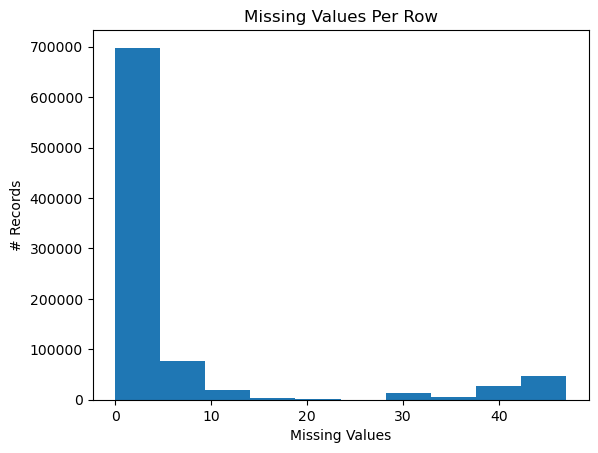

In [17]:
# How much data is missing in each row of the dataset?

sum_nans = data_azdias.isnull().sum(axis=1)
plt.hist(sum_nans, bins=10)
plt.title('Missing Values Per Row')
plt.ylabel('# Records')
plt.xlabel('Missing Values');


In [18]:
print(f'(Rows, Columns) in data: {data_azdias.shape}')

(Rows, Columns) in data: (891221, 77)


In [19]:
# Explore amount of records we loose with different thresholds
sum_nans.max()

for i in range(5, 50):
    print(f'Threshold {i}: {(sum_nans>i).sum()} | '
          f'{(sum_nans>=i).sum()/data_azdias.shape[0]*100:.2f}%')

Threshold 5: 169919 | 21.68%
Threshold 6: 144802 | 19.07%
Threshold 7: 130396 | 16.25%
Threshold 8: 117085 | 14.63%
Threshold 9: 115511 | 13.14%
Threshold 10: 110290 | 12.96%
Threshold 11: 109107 | 12.38%
Threshold 12: 108688 | 12.24%
Threshold 13: 101491 | 12.20%
Threshold 14: 97139 | 11.39%
Threshold 15: 96498 | 10.90%
Threshold 16: 95961 | 10.83%
Threshold 17: 94399 | 10.77%
Threshold 18: 93940 | 10.59%
Threshold 19: 93781 | 10.54%
Threshold 20: 93612 | 10.52%
Threshold 21: 93445 | 10.50%
Threshold 22: 93368 | 10.49%
Threshold 23: 93287 | 10.48%
Threshold 24: 93206 | 10.47%
Threshold 25: 93183 | 10.46%
Threshold 26: 93179 | 10.46%
Threshold 27: 93163 | 10.46%
Threshold 28: 93157 | 10.45%
Threshold 29: 93153 | 10.45%
Threshold 30: 92945 | 10.45%
Threshold 31: 89960 | 10.43%
Threshold 32: 79144 | 10.09%
Threshold 33: 75233 | 8.88%
Threshold 34: 75149 | 8.44%
Threshold 35: 74611 | 8.43%
Threshold 36: 74190 | 8.37%
Threshold 37: 74113 | 8.32%
Threshold 38: 73976 | 8.32%
Threshold 39: 73

In [20]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
divider = 10

data_fm = data_azdias[sum_nans<=divider]
data_mm = data_azdias[sum_nans>divider]

print(f'Total records in Group 1: {data_fm.shape[0]} | {data_fm.shape[0]/data_azdias.shape[0]*100:.2f}%')
print(f'Total records in Group 2: {data_mm.shape[0]} | {data_mm.shape[0]/data_azdias.shape[0]*100:.2f}%')


Total records in Group 1: 780931 | 87.62%
Total records in Group 2: 110290 | 12.38%


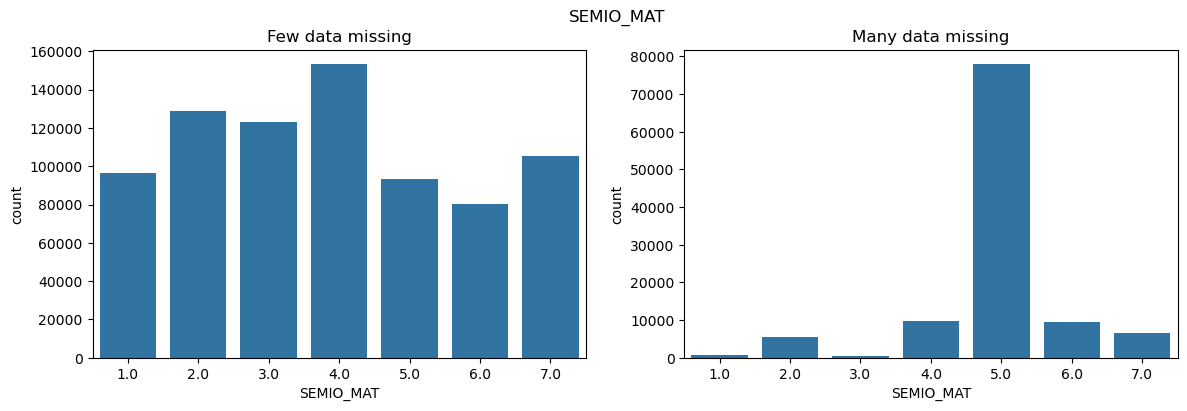

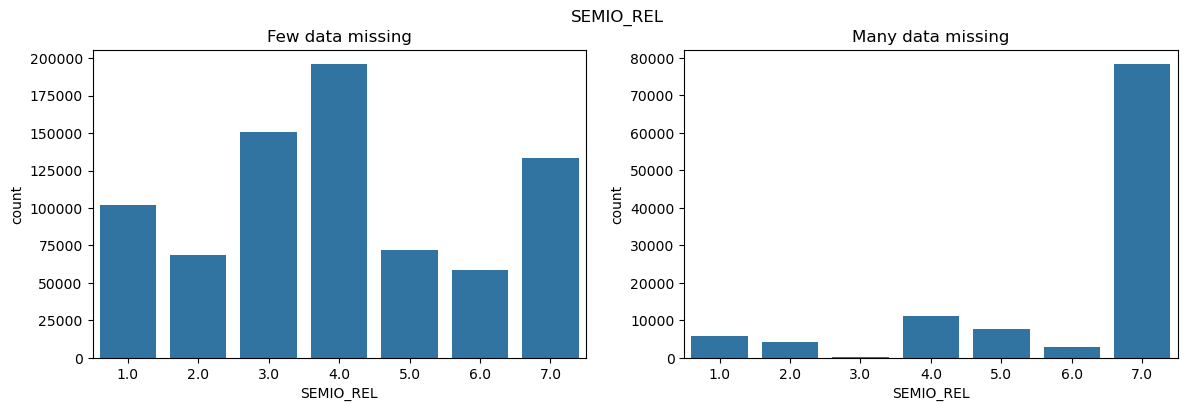

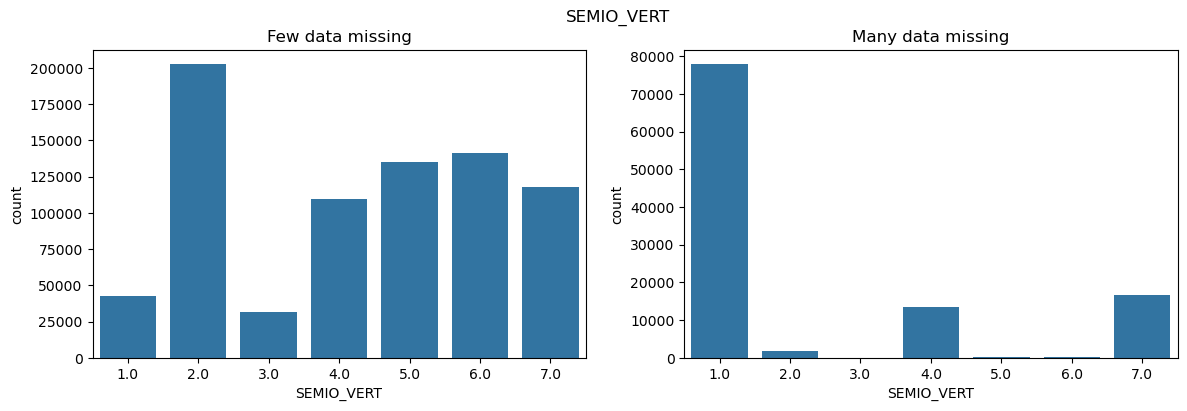

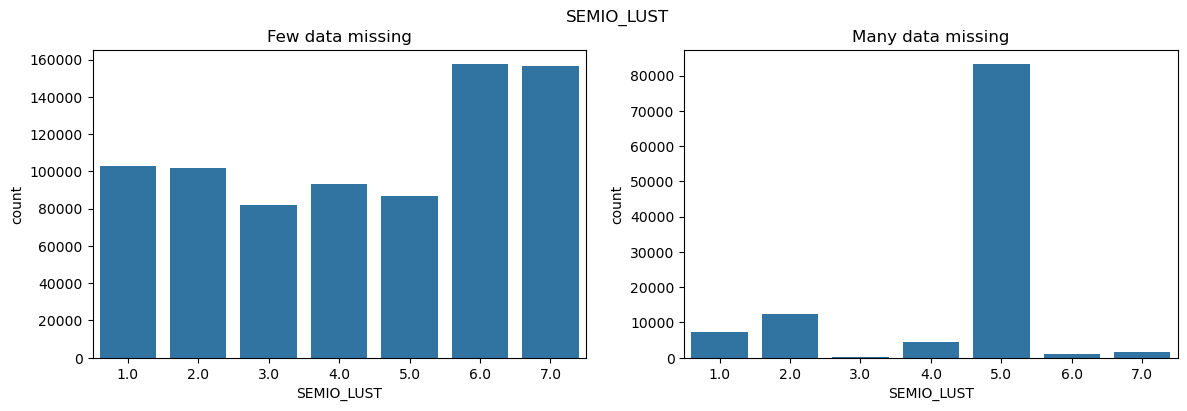

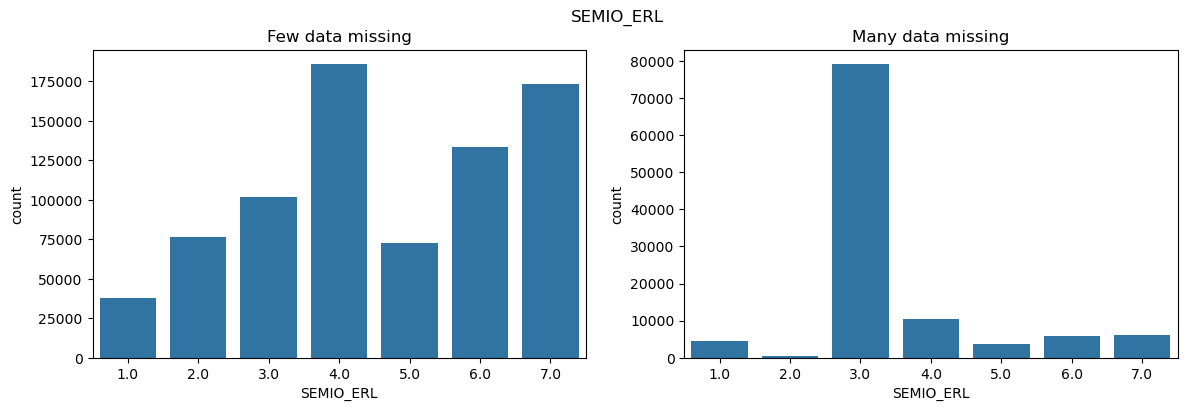

In [21]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Function to plot both groups side by side
def dist_compare(few_dataset, many_dataset, column):
    fig = plt.figure(figsize=(14,4))
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Few data missing')
    sns.countplot(x=few_dataset[column])

    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Many data missing')
    sns.countplot(x=many_dataset[column]);

    fig.suptitle(column)
    plt.show()

# Create new datasets that have False instead of NaNs
few_dataset = data_fm.fillna(False)
many_dataset = data_mm.fillna(False)

# Get 5 columns that has less missing values
columns_fm = data_azdias.isna().sum().sort_values().index[:5]

for column in columns_fm:
    column
    dist_compare(few_dataset, many_dataset, column)




Each of the graphs shows a very different distribution for each group. The graphs for the group with less than 10% of missing values, are well distributed, while the graphs of the other group shows that the data concentrates around a single value.

Lets explore columns that have at least 1 value missing.

In [22]:
data_azdias.isna().sum()[data_azdias.isna().sum()>0].sort_values()[0:5].to_frame(name='Missing values')

,Missing values
ALTERSKATEGORIE_GROB,2881
RETOURTYP_BK_S,4854
LP_STATUS_GROB,4854
LP_STATUS_FEIN,4854
GFK_URLAUBERTYP,4854


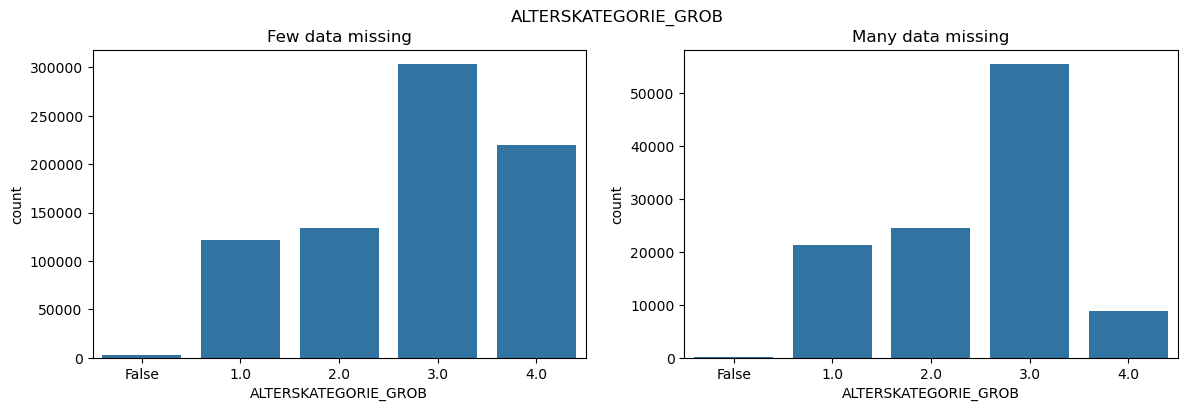

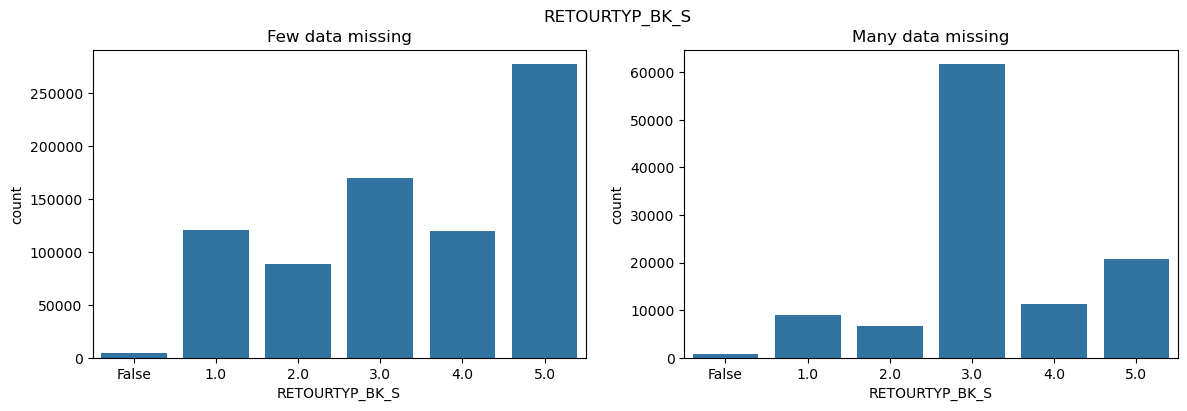

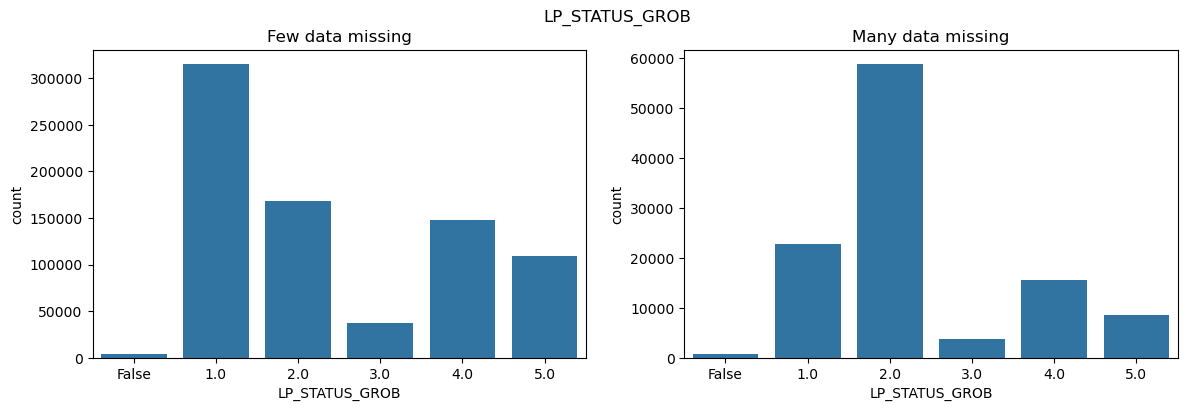

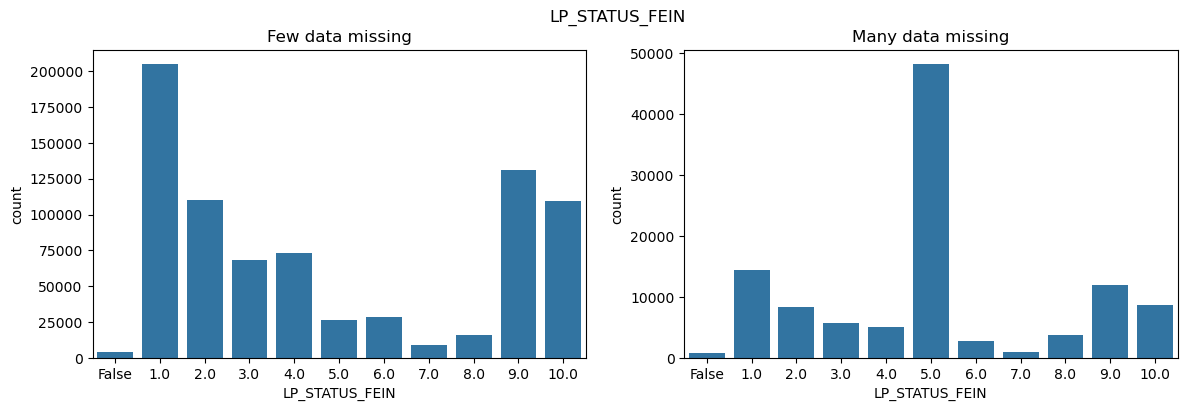

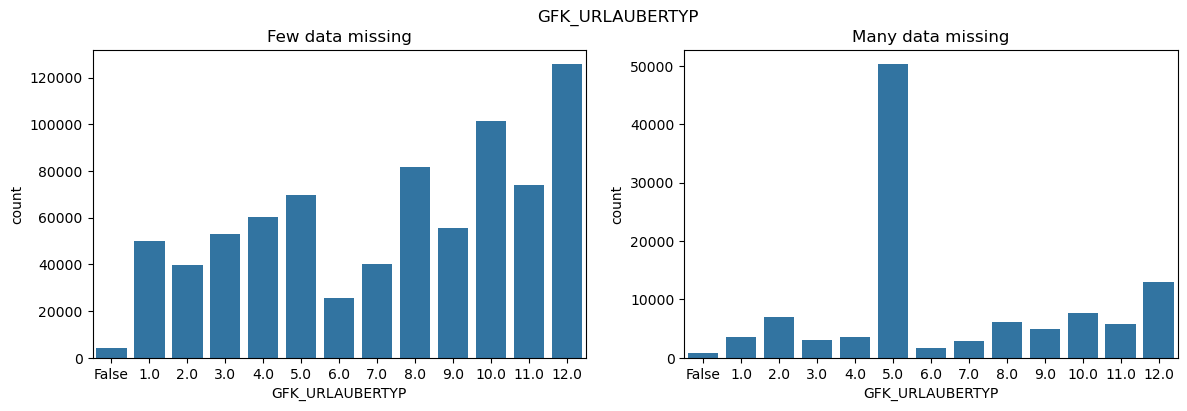

In [23]:
# Distribution of 5 first columns with at least one missing value
columns_mm = data_azdias.isna().sum()[data_azdias.isna().sum()>0].sort_values().index[:5]

for column in columns_mm:
    column
    dist_compare(few_dataset, many_dataset, column)



In [24]:
print(f'Rows - Columns Azdidas Data: {data_azdias.shape}')

Rows - Columns Azdidas Data: (891221, 77)


In [25]:
# Drop records with more than 15% of missing values
data_azdias = data_azdias[ sum_nans <= divider ]

In [26]:
print(f'(Rows, Columns) in data: {data_azdias.shape}')

(Rows, Columns) in data: (780931, 77)


#### Discussion 1.1.3: Assess Missing Data in Each Row

We divided the dataset into two groups:

**Group A**: records with 10 or fewer missing values
**Group B**: records with more than 10 missing values

We plotted the distribution of data values on columns for each group and we can see that graphs for Group A (<=10 missing values) is well distributed, indicated a diverse and balanced subset. Graphs of Group B (>10 missing values) exhibits a heavily skewed distribution, with data concentrating around a single value. This suggests a lack of variability and potential biases in those records, and although they represent around 12% of the dataset, eliminating them is crucial to avoid potential problems with our classification model.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [27]:
# How many features are there of each data type?
feat_info['type'].value_counts().to_frame()

,count
type,
ordinal,49
categorical,21
numeric,7
mixed,7
interval,1


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [28]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Get categorical columns
cat_columns = feat_info.loc[feat_info['type'] == 'categorical', 'attribute'].values

binary_columns = []
multilevel_columns = []

for column in cat_columns:
    try:
        if data_azdias[column].nunique() == 2:
            binary_columns.append(column)
        else:
            multilevel_columns.append(column)
    except:
        pass

print('Binary Columns')
for i in range(len(binary_columns)):
    print(f'- {binary_columns[i]}')    



Binary Columns
- ANREDE_KZ
- GREEN_AVANTGARDE
- SOHO_KZ
- VERS_TYP
- OST_WEST_KZ


In [29]:
print('Values in Binary Columns\n')

for column in binary_columns:
    values = data_azdias[column].unique()
    print(f'{column}: ')
    for i in range(len(values)):
        if not pd.isna(values[i]):
            print(f'- {values[i]}')

Values in Binary Columns

ANREDE_KZ: 
- 2.0
- 1.0
GREEN_AVANTGARDE: 
- 0
- 1
SOHO_KZ: 
- 1.0
- 0.0
VERS_TYP: 
- 2.0
- 1.0
OST_WEST_KZ: 
- W
- O


In [30]:
# Check how many missing values there are in those columns
sum_nans = data_azdias.isnull().sum()
for i in range(len(binary_columns)):
    column = binary_columns[i]
    print(f'Missing values in column {column}: {sum_nans[column]} '
      f'| {sum_nans[column]/data_azdias.shape[0]*100:.2f}%')

Missing values in column ANREDE_KZ: 0 | 0.00%
Missing values in column GREEN_AVANTGARDE: 0 | 0.00%
Missing values in column SOHO_KZ: 0 | 0.00%
Missing values in column VERS_TYP: 34756 | 4.45%
Missing values in column OST_WEST_KZ: 0 | 0.00%


In [31]:
# Drop variable VERS_TYP with 4.45% of missing values
columns_drop = ['VERS_TYP']

data_azdias.drop(columns=columns_drop, inplace=True)

In [32]:
# Replace W with 0 and O with 1 in the OST_WEST_KZ column

data_azdias['OST_WEST_KZ'].replace(['W','O'], [0,1], inplace=True);

In [33]:
# Sanity check of values in Binary Columns
print('Values in Binary Columns\n')

for column in binary_columns:
    try:
        values = data_azdias[column].unique()
        print(f'{column}: ')
        for i in range(len(values)):
            if not pd.isna(values[i]):
                print(f'- {values[i]}')
    except:
        pass

Values in Binary Columns

ANREDE_KZ: 
- 2.0
- 1.0
GREEN_AVANTGARDE: 
- 0
- 1
SOHO_KZ: 
- 1.0
- 0.0
OST_WEST_KZ: 
- 0
- 1


In [34]:
# Multilevel columns

print('\nMultilevel Columns')
for i in range(len(multilevel_columns)):
    print(f'- {multilevel_columns[i]}')  


Multilevel Columns
- CJT_GESAMTTYP
- FINANZTYP
- GFK_URLAUBERTYP
- LP_FAMILIE_FEIN
- LP_FAMILIE_GROB
- LP_STATUS_FEIN
- LP_STATUS_GROB
- NATIONALITAET_KZ
- SHOPPER_TYP
- ZABEOTYP
- GEBAEUDETYP
- CAMEO_DEUG_2015
- CAMEO_DEU_2015


In [35]:
# Check how many missing values there are in those columns
sum_nans = data_azdias.isnull().sum()
for i in range(len(multilevel_columns)):
    column = multilevel_columns[i]
    print(f'Missing values in column {column}: {sum_nans[column]} '
      f'| {sum_nans[column]/data_azdias.shape[0]*100:.2f}%')

Missing values in column CJT_GESAMTTYP: 4016 | 0.51%
Missing values in column FINANZTYP: 0 | 0.00%
Missing values in column GFK_URLAUBERTYP: 4016 | 0.51%
Missing values in column LP_FAMILIE_FEIN: 29087 | 3.72%
Missing values in column LP_FAMILIE_GROB: 29087 | 3.72%
Missing values in column LP_STATUS_FEIN: 4016 | 0.51%
Missing values in column LP_STATUS_GROB: 4016 | 0.51%
Missing values in column NATIONALITAET_KZ: 32101 | 4.11%
Missing values in column SHOPPER_TYP: 34756 | 4.45%
Missing values in column ZABEOTYP: 0 | 0.00%
Missing values in column GEBAEUDETYP: 0 | 0.00%
Missing values in column CAMEO_DEUG_2015: 3828 | 0.49%
Missing values in column CAMEO_DEU_2015: 3828 | 0.49%


In [36]:
# Reencode multilevel variables using dummies

columns_keep = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
                'LP_STATUS_GROB','ZABEOTYP', 'GEBAEUDETYP', 
                'CAMEO_DEUG_2015']

# Check the number of unique values in multilevel columns
sum_unique = 0
for column in columns_keep:
    try:
        print(f'{column}: {data_azdias[column].nunique()} unique values')
        sum_unique += data_azdias[column].nunique()
    except:
        pass

print(f'{sum_unique} new columns will be added after one hot encoding\n')
print(f'data_azdias will have {data_azdias.shape[1]+sum_unique-len(columns_keep)} columns\n')

CJT_GESAMTTYP: 6 unique values
FINANZTYP: 6 unique values
GFK_URLAUBERTYP: 12 unique values
LP_STATUS_GROB: 5 unique values
ZABEOTYP: 6 unique values
GEBAEUDETYP: 7 unique values
CAMEO_DEUG_2015: 9 unique values
51 new columns will be added after one hot encoding

data_azdias will have 120 columns



In [37]:
# One hot encoding for selected columns
for column in columns_keep:
    try:
        data_azdias = pd.get_dummies(data_azdias, columns=[column])
    except:
        pass


In [38]:
# Sanity check: See new shape of our data
print(f'(Rows, Columns) in data: {data_azdias.shape}')

(Rows, Columns) in data: (780931, 120)


In [39]:
# Drop selected multilevel columns from the data

columns_drop = ['LP_FAMILIE_GROB', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN',
                'CAMEO_DEU_2015', 'NATIONALITAET_KZ', 'SHOPPER_TYP']

data_azdias.drop(columns=columns_drop, inplace=True)

In [40]:
# Sanity check: See new shape of our data
print(f'(Rows, Columns) in data: {data_azdias.shape}')

(Rows, Columns) in data: (780931, 114)


#### Discussion 1.2.1: Re-Encode Categorical Features

The data has 5 binary categorical variables:
- **ANREDE_KZ:** Gender
- **GREEN_AVANTGARDE:** Membership in enviromental sustainability
- **SOHO_KZ:** Small office / home office flag
- **VERS_TYP:** Insurance typology
- **OST_WEST_KZ:** Building location

We decided to drop the column **VERS_TYP**, as it has 4.45% of missing values and can be supplemented by other columns. For column **OST_WEST_KZ**, we replaced W wtih 0 and O with 1.

From the multilevel categorical variables, we decided to keep and use one hot encoding for the following columns:

- **CJT_GESAMTTYP**: Overall customer type classification
- **FINANZTYP**: Financial type
- **GFK_URLAUBERTYP**: Vacation habits
- **LP_STATUS_GROB**: Social status, rough scale
- **ZABEOTYP**: Energy consumption typology
- **GEBAEUDETYP**: Type of building (residential vs. commercial)
- **CAMEO_DEUG_2015**: Wealth / Life Stage Typology, rough scale


The following columns were droped to reduce the complexity of the data, as their information can be infered from other columns:

- **LP_FAMILIE_GROB**: Family type, rough scale.
- **LP_FAMILIE_FEIN**: Family type, fine scale.
- **LP_STATUS_FEIN**: Social status, fine scale. It is supplemented by LP_STATUS_GROB
- **NATIONALITAET_KZ**: Nationality based on given name analysis
- **SHOPPER_TYP**: Shopper typology
- **CAMEO_DEU_2015**: German CAMEO: Wealth / Life Stage Typology, detailed scale. It is supplemented by CAMEO_DEUG_2015

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [41]:
# Show mixed variables

mixed_columns = feat_info[ feat_info['type'] == 'mixed' ]['attribute']
mixed_columns.to_frame()

,attribute
15,LP_LEBENSPHASE_FEIN
16,LP_LEBENSPHASE_GROB
22,PRAEGENDE_JUGENDJAHRE
56,WOHNLAGE
59,CAMEO_INTL_2015
64,KBA05_BAUMAX
79,PLZ8_BAUMAX


In [42]:
# Check how many missing values there are in those columns
sum_nans = data_azdias.isnull().sum()
for i in range(len(mixed_columns)):
    try:
        column = mixed_columns.iloc[i]
        print(f'Missing values in column {column}: {sum_nans[column]} '
          f'| {sum_nans[column]/data_azdias.shape[0]*100:.2f}%')
    except:
        pass

Missing values in column LP_LEBENSPHASE_FEIN: 46816 | 5.99%
Missing values in column LP_LEBENSPHASE_GROB: 44136 | 5.65%
Missing values in column PRAEGENDE_JUGENDJAHRE: 26539 | 3.40%
Missing values in column WOHNLAGE: 0 | 0.00%
Missing values in column CAMEO_INTL_2015: 3828 | 0.49%
Missing values in column PLZ8_BAUMAX: 8218 | 1.05%


In [43]:
# DROP COLUMNS LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, PLZ8_BAUMAX
coumns_drop = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX']
data_azdias.drop(columns = coumns_drop, inplace = True)

In [44]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Create variable PJ_DECADE with information about the decade
# 4: 40s | 5: 50s | 6: 60s | 7: 70s | 8: 80s | 9: 90s
decade_mappings = {1: 4, 2: 4, 3: 5, 4: 5, 5: 6, 6: 6, 7: 6, 8: 7,
                   9: 7, 10: 8, 11: 8, 12: 8, 13: 8, 14: 9, 15: 9 }
data_azdias['PJ_DECADE'] = data_azdias['PRAEGENDE_JUGENDJAHRE'].replace(decade_mappings)

# Create variable PJ_MOVEMENT with information about the movement
# 1: Mainstream \ 2: Avantgarde
movement_mappings = {1: 1, 2: 2, 3: 1, 4: 2, 5: 1, 6: 2, 7: 2, 8: 1, 
                     9: 2, 10: 1, 11: 2, 12: 1, 13: 2, 14: 1, 15: 2}
data_azdias['PJ_MOVEMENT'] = data_azdias['PRAEGENDE_JUGENDJAHRE'].replace(movement_mappings)

# DROP COLUMN PRAEGENDE_JUGENDJAHRE
data_azdias.drop(columns = ['PRAEGENDE_JUGENDJAHRE'], inplace = True)

In [45]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Create variable CAMEO_WEALTH with information about the wealth
# 1: Wealthy Households | 2: Prosperous Households | 3: Comfortable Households
# 4: Less Affluent Households | 5: Poorer Households
wealth_mappings = {'11': 1, '12': 1, '13': 1, '14': 1, '15': 1,
                   '21': 2, '22': 2, '23': 2, '24': 2, '25': 2,
                   '31': 3, '32': 3, '33': 3, '34': 3, '35': 3,
                   '41': 4, '42': 4, '43': 4, '44': 4, '45': 4,
                   '51': 5, '52': 5, '53': 5, '54': 5, '55': 5}
data_azdias['CAMEO_WEALTH'] = data_azdias['CAMEO_INTL_2015'].replace(wealth_mappings)

# Create variable CAMEO_STAGE with information about Life Stage
# 1: Pre-Family Couples & Singles, 2: Young Couples With Children, 3: Families With School Age Children,
# 4: Older Families &  Mature Couples, 5: Elders In Retirement
stage_mappings = {'11': 1, '12': 2, '13': 3, '14': 4, '15': 5, 
                  '21': 1, '22': 2, '23': 3, '24': 4, '25': 5,
                  '31': 1, '32': 2, '33': 3, '34': 4, '35': 5, 
                  '41': 1, '42': 2, '43': 3, '44': 4, '45': 5,
                  '51': 1, '52': 2, '53': 3, '54': 4, '55': 5}
data_azdias['CAMEO_STAGE'] = data_azdias['CAMEO_INTL_2015'].replace(stage_mappings)
# DROP COLUMN CAMEO_INTL_2015
data_azdias.drop(columns = ['CAMEO_INTL_2015'], inplace = True)

In [46]:
# Replace records where WOHNLAGE has a value of 8 (new building in rural neighborhood)
# with 7 (rural neighborhood)
data_azdias['WOHNLAGE'] = data_azdias['WOHNLAGE'].replace({8: 7})

In [47]:
# Check shape of data, it should have now 85 columns
data_azdias.shape

(780931, 113)

#### Discussion 1.2.2: Engineer Mixed-Type Features

For the mixed columns, we decided to remove the following columns:
- **LP_LEBENSPHASE_FEIN**: This column contains information about the life phase segmentation, but there are other fields that can complement the information, like LP_FAMILIE_GROB, HH_EINKOMMEN_SCORE, ALTER_HH.
- **LP_LEBENSPHASE_GROB**: This column contains information about the life phase segmentation, but there are other fields that can complement the information, like LP_FAMILIE_GROB, HH_EINKOMMEN_SCORE, ALTER_HH.
- **PLZ8_BAUMAX**: This column indicate the predominant building type in the PLZ8 region, but we have other fields that capture similar information, for example, GEBAEUDETYP, KBA05_BAUMAX

Columns *PRAEGENDE_JUGENDJAHRE*, *CAMEO_STAGE* and *WOHNLAGE* were modified to enhance the categorization process.

**PRAEGENDE_JUGENDJAHRE**: (Dominating movement of person's youth) We separated the data in two columns:

- *PJ_MOVEMENT*: Contains information about the type of movement
    - Mainstream
    - Avantgarde
- *PJ_DECADE*: Contains information about the decade
    - 4: 40s
    - 5: 50s
    - 6: 60s
    - 7: 70s
    - 8: 80s
    - 9: 90s


**CAMEO_INTL_2015**: (German CAMEO: Wealth / Life Stage Typology) We deparated the data in two columns:

- *CAMEO_WEALTH*: Information about wealth:
1. Wealthy Households
2. Prosperous Households
3. Comfortable Households
4. Less Affluent Households
5. Poorer Households

*CAMEO_STAGE*: Information about the Life Stage
1. Pre-Family Couples & Singles
2. Young Couples With Children
3. Families With School Age Children
4. Older Families & Mature Couples
5. Elders In Retirement

**WOHNLAGE**: (Neighborhood quality (or rural flag)) 
The first 8 values describe the quality neighborhood, and jut one refers to a new building in rural neighborhooh. We decided to replace that value with the value of rural neighborhood of the neighbouthood and

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [48]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
data_azdias.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,MOBI_REGIO,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PJ_DECADE,PJ_MOVEMENT,CAMEO_WEALTH,CAMEO_STAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,1.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,9.0,1.0,5,1
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,3.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,9.0,2.0,2,4
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,7.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,4.0,1.0,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,7.0,1.0,1,2
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,7.0,1.0,4,3
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,2.

In [49]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

data_azdias[:1].transpose()


,1
ALTERSKATEGORIE_GROB,1.0
ANREDE_KZ,2.0
FINANZ_MINIMALIST,1.0
FINANZ_SPARER,5.0
FINANZ_VORSORGER,2.0
FINANZ_ANLEGER,5.0
FINANZ_UNAUFFAELLIGER,4.0
FINANZ_HAUSBAUER,5.0
GREEN_AVANTGARDE,0
HEALTH_TYP,3.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [50]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...

    # Replace values that indicate the data is missing with nans
    j = 0
    for index, row in feat_info.iterrows():
        j += 1
        att = row['attribute']
        att_type = row['type']
        att_missing_values = row['missing_or_unknown'].replace('[', '').replace(']', '').split(',')
    
        for i in range(len(att_missing_values)):
            value = att_missing_values[i]
            try:
                value = int(value)
            except:
                value = str(value)
                
            if att_missing_values[i] != '':
                df.loc[df[att]==value, att ] = np.nan
                df[att]==att_missing_values[i]
   

    
    # remove selected columns and rows, ...
    columns_drop = ['KKK', 'REGIOTYP', 'ALTER_HH', 'GEBURTSJAHR', 
                    'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ']
    df.drop(columns = columns_drop, inplace = True)

    columns_drop = ['VERS_TYP']
    df.drop(columns = columns_drop, inplace = True)

    columns_drop = ['LP_FAMILIE_GROB', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN',
                'CAMEO_DEU_2015', 'NATIONALITAET_KZ', 'SHOPPER_TYP']
    df.drop(columns = columns_drop, inplace = True)
    
    columns_drop = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX']
    df.drop(columns = columns_drop, inplace = True)

    # One hot encoding for selected categorical columns
    columns_keep = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
                'LP_STATUS_GROB','ZABEOTYP', 'GEBAEUDETYP', 
                'CAMEO_DEUG_2015']

    
    for column in columns_keep:
        try:
            df = pd.get_dummies(df, columns=[column])
        except:
            pass

    
    # Remove rows with more than 10 of values missing
    sum_nans = df.isnull().sum(axis=1)
    divider = 10
    df = df[ sum_nans <= divider ]
    
    # select, re-encode, and engineer column values.

    # Reencode values of OST_WEST_KZ binary columns
    df['OST_WEST_KZ'].replace(['W','O'], [0,1], inplace=True);

    # Separate PRAEGENDE_JUGENDJAHRE into two categorial columns
    
    # Create variable PJ_DECADE with information about the decade
    # 4: 40s | 5: 50s | 6: 60s | 7: 70s | 8: 80s | 9: 90s
    decade_mappings = {1: 4, 2: 4, 3: 5, 4: 5, 5: 6, 6: 6, 7: 6, 8: 7,
                       9: 7, 10: 8, 11: 8, 12: 8, 13: 8, 14: 9, 15: 9 }
    df['PJ_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].replace(decade_mappings)

    # Create variable PJ_MOVEMENT with information about the movement
    # 1: Mainstream \ 2: Avantgarde
    movement_mappings = {1: 1, 2: 2, 3: 1, 4: 2, 5: 1, 6: 2, 7: 2, 8: 1, 
                         9: 2, 10: 1, 11: 2, 12: 1, 13: 2, 14: 1, 15: 2}
    df['PJ_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].replace(movement_mappings)

    # DROP COLUMN PRAEGENDE_JUGENDJAHRE
    df.drop(columns = ['PRAEGENDE_JUGENDJAHRE'], inplace = True)


    # Separate CAMEO_INTL_2015 into two categorial columns
    
    # Create variable CAMEO_WEALTH with information about the wealth
    # 1: Wealthy Households | 2: Prosperous Households | 3: Comfortable Households
    # 4: Less Affluent Households | 5: Poorer Households
    wealth_mappings = {'11': 1, '12': 1, '13': 1, '14': 1, '15': 1,
                       '21': 2, '22': 2, '23': 2, '24': 2, '25': 2,
                       '31': 3, '32': 3, '33': 3, '34': 3, '35': 3,
                       '41': 4, '42': 4, '43': 4, '44': 4, '45': 4,
                       '51': 5, '52': 5, '53': 5, '54': 5, '55': 5}
    df['CAMEO_WEALTH'] = df['CAMEO_INTL_2015'].replace(wealth_mappings)

    # Create variable CAMEO_STAGE with information about Life Stage
    # 1: Pre-Family Couples & Singles, 2: Young Couples With Children, 3: Families With School Age Children,
    # 4: Older Families &  Mature Couples, 5: Elders In Retirement
    stage_mappings = {'11': 1, '12': 2, '13': 3, '14': 4, '15': 5, 
                      '21': 1, '22': 2, '23': 3, '24': 4, '25': 5,
                      '31': 1, '32': 2, '33': 3, '34': 4, '35': 5, 
                      '41': 1, '42': 2, '43': 3, '44': 4, '45': 5,
                      '51': 1, '52': 2, '53': 3, '54': 4, '55': 5}
    df['CAMEO_STAGE'] = df['CAMEO_INTL_2015'].replace(stage_mappings)

    # DROP COLUMN CAMEO_INTL_2015
    df.drop(columns = ['CAMEO_INTL_2015'], inplace = True)

    # Replace records where WOHNLAGE has a value of 8 with 7
    df['WOHNLAGE'] = df['WOHNLAGE'].replace({8: 7})

    
    # Return the cleaned dataframe.
    return df

In [66]:
# Sanity check. Test cleaning function

# Load in the general demographics data.
data_check = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [67]:
data_check.shape

(891221, 85)

In [68]:
data_check.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [69]:
data_clean = clean_data(data_check)

In [70]:
data_clean.shape

(784088, 113)

In [71]:
data_azdias.shape

(780931, 113)

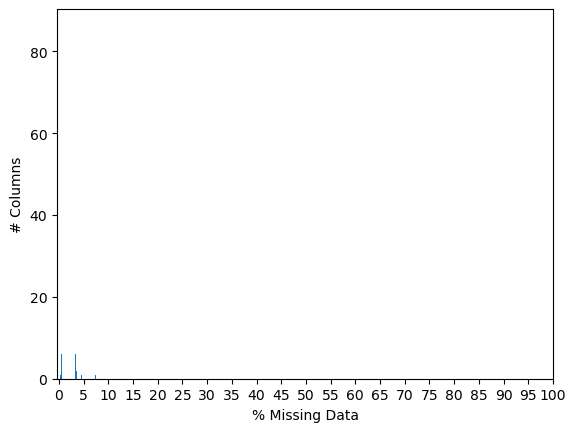

In [72]:
# Investigate patterns in the amount of missing data in each column.
nans_by_column = (data_clean.isna().sum() / len(data_clean)) * 100
plt.hist(nans_by_column, bins=100);
plt.ylabel('# Columns')
plt.xlabel('% Missing Data')
plt.xticks(range(0,101,5));

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [73]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Use SimpleImputer with the strategy most frequent to not create decimals
# in categorical columns
imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_imp = imp_mean.fit_transform(data_clean)

In [74]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imp)

### Discussion 2.1: Apply Feature Scaling

Before proceding with the dimensionality reduction and data clustering, we took the following steps:

- **Imputation**: Missing values were addressed using a frequent value imputation strategy. This is preffered to avoid the introduction of decimal values in categorical features.
- **Feature Scaling**: We used a Standard Scaler to standarize the data to avoid that features with larger magnitudes dominate the PCA.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [75]:
# Apply PCA to the data.

pca = PCA()
data_pca = pca.fit_transform(data_scaled)

In [76]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca, threshold=0):
    '''
    Creates a scree plot associated with the principal components
    INPUT: pca - the result of instantian of PCA in scikit learn
    OUTPUT: None
    '''
    
    num_components = len(pca.explained_variance_ratio_)
    pca_cum_var = np.cumsum(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")

    if threshold>0:
        comp_threshold = min(np.where(np.cumsum(pca.explained_variance_ratio_)>threshold)[0]+1)
        ax.axvline(comp_threshold, color='red', linestyle='dotted')
        ax.axhline(pca_cum_var[comp_threshold], color='red', linestyle='dotted')
        ax.annotate(f"{comp_threshold} Comp", xy=[comp_threshold+6, threshold], va="bottom", ha="center", fontsize=12)
        
    plt.title('Explained Variance Per Principal Component')

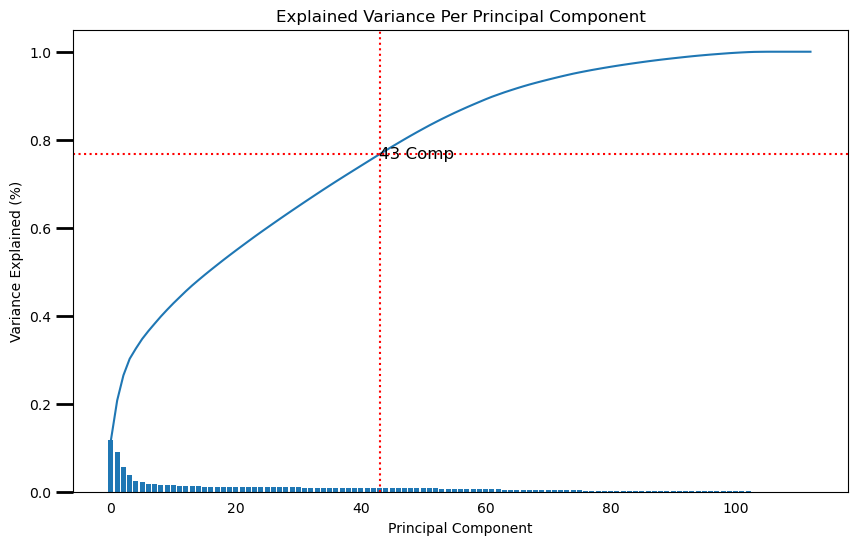

In [77]:
# Create scree plot and get number of components needed to explain 75% of variance
scree_plot(pca, 0.75)

In [78]:
# Re-apply PCA to the data with 43 components
pca = PCA(n_components=43)
data_pca = pca.fit_transform(data_scaled)
print(f'Variance explained: {np.cumsum(pca.explained_variance_ratio_.sum())*100}%')

Variance explained: [75.81839207]%


### Discussion 2.2: Perform Dimensionality Reduction

We applied Principal Component Analysis (PCA) to reduce the dimensionality of the dataset. A scree plot was generated to determine the number of principal components that could explain an 75% of the total variance in the data.

We found that 43 components explain a total of 75.84% of the variance in the data. This seems like a good number to represent the information originally contained in 85 columns.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [79]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def weights_pca(data, pca, n_comp, limit=0):
    
    # Get the weights for the selected component
    weights = pd.DataFrame(np.round(pca.components_[[n_comp-1]], 4), columns = data.keys()).T.sort_values(by = [0], ascending = False)

    if limit>0:
        weights_head = weights.head(limit)
        weights_tail = weights.tail(limit)
        weights_return = pd.concat([weights_head, weights_tail])
    else:
        weights_return = weights

    return weights_return


def plot_pca(data, pca, n_comp):
    '''
	Plot the features with the most absolute variance for given pca component 
	'''
    comp_weights = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()).iloc[n_comp-1]
    comp_weights.sort_values(ascending=False, inplace=True)
    comp_weights = pd.concat([comp_weights.head(5), comp_weights.tail(5)])
    
    comp_weights.plot(kind='bar', title='Component ' + str(n_comp))
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()

In [80]:
# Show amount of variance explained in each component
for i in range(len(pca.components_)):
    var_ratio = pca.explained_variance_ratio_[i]
    print(f'Comp {i}: {(var_ratio*100).round(2)}%')

Comp 0: 11.73%
Comp 1: 9.02%
Comp 2: 5.71%
Comp 3: 3.75%
Comp 4: 2.35%
Comp 5: 2.16%
Comp 6: 1.81%
Comp 7: 1.67%
Comp 8: 1.64%
Comp 9: 1.53%
Comp 10: 1.46%
Comp 11: 1.38%
Comp 12: 1.37%
Comp 13: 1.29%
Comp 14: 1.21%
Comp 15: 1.18%
Comp 16: 1.15%
Comp 17: 1.13%
Comp 18: 1.12%
Comp 19: 1.09%
Comp 20: 1.07%
Comp 21: 1.06%
Comp 22: 1.05%
Comp 23: 1.04%
Comp 24: 1.02%
Comp 25: 1.0%
Comp 26: 1.0%
Comp 27: 0.99%
Comp 28: 0.98%
Comp 29: 0.97%
Comp 30: 0.96%
Comp 31: 0.96%
Comp 32: 0.95%
Comp 33: 0.94%
Comp 34: 0.93%
Comp 35: 0.92%
Comp 36: 0.91%
Comp 37: 0.9%
Comp 38: 0.89%
Comp 39: 0.89%
Comp 40: 0.89%
Comp 41: 0.88%
Comp 42: 0.88%


In [81]:
# Display weights for component 1
weights_pca1 = weights_pca(data_azdias, pca, 1, 5)
weights_pca1

,0
FINANZ_MINIMALIST,0.2123
MOBI_REGIO,0.2015
PLZ8_ANTG1,0.1935
KBA05_ANTG1,0.1915
KBA05_GBZ,0.1897
CAMEO_WEALTH,-0.1861
PLZ8_ANTG4,-0.1865
HH_EINKOMMEN_SCORE,-0.1866
PLZ8_ANTG3,-0.1937
LP_STATUS_GROB_1.0,-0.2024


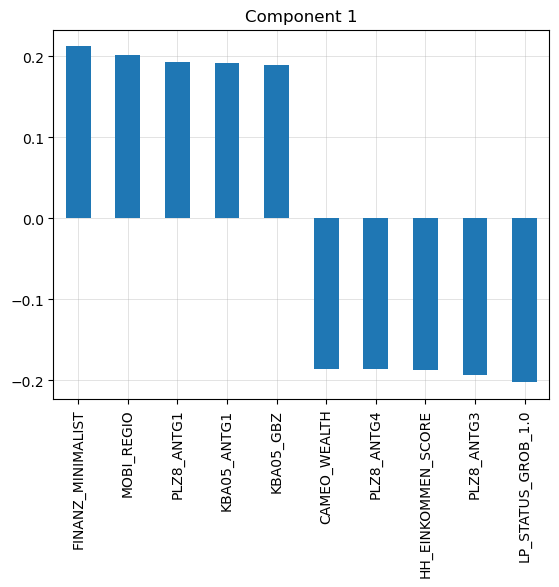

In [82]:
plot_pca(data_azdias, pca, 1)

In [83]:
# Display weights for component 2
weights_pca2 = weights_pca(data_azdias, pca, 2, 5)
weights_pca2

,0
ALTERSKATEGORIE_GROB,0.2298
FINANZ_VORSORGER,0.2161
ZABEOTYP_3.0,0.2064
SEMIO_ERL,0.1872
SEMIO_LUST,0.1614
SEMIO_TRADV,-0.2082
FINANZ_UNAUFFAELLIGER,-0.2148
SEMIO_REL,-0.2156
FINANZ_SPARER,-0.2163
PJ_DECADE,-0.2262


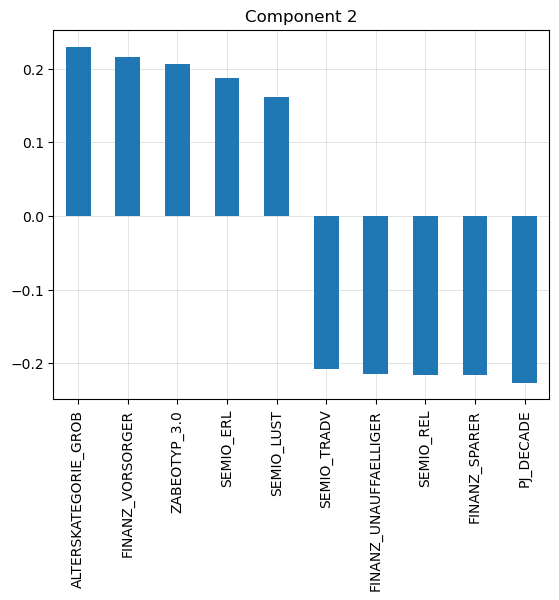

In [84]:
plot_pca(data_azdias, pca, 2)

In [85]:
# Display weights for component 3
weights_pca3 = weights_pca(data_azdias, pca, 3, 5)
weights_pca3

,0
ANREDE_KZ,0.3594
SEMIO_KAEM,0.3273
SEMIO_DOM,0.2972
SEMIO_KRIT,0.2747
SEMIO_ERL,0.2018
FINANZTYP_5.0,-0.1428
SEMIO_KULT,-0.2540
SEMIO_FAM,-0.2632
SEMIO_SOZ,-0.2635
SEMIO_VERT,-0.3346


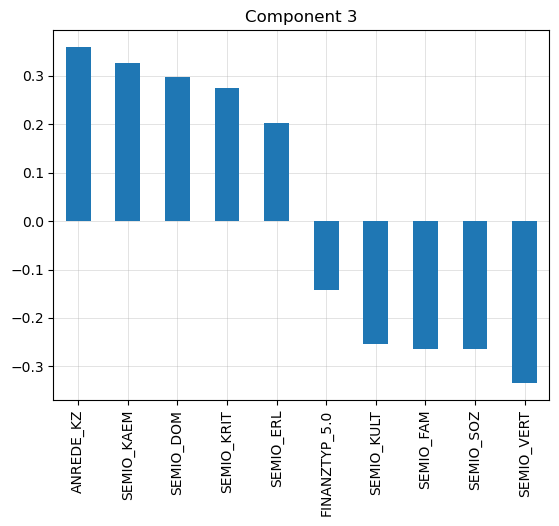

In [86]:
plot_pca(data_azdias, pca, 3)

### Discussion 2.3: Interpret Principal Components

From the weights of each PCA, we have the following observations:

**Component 1**: This component has a possitive relation with the following fields.
- FINANZ_MINIMALIST
- MOBI_REGIO
- PLZ8_ANTG1
- KBA05_ANTG1
- KBA05_GBZ A negative relation with these:
- LP_STATUS_GROB_1.0
- PLZ8_ANTG3
- PLZ8_ANTG4
- HH_EINKOMMEN_SCORE
- CAMEO_WEALTH

This component is more related with the financial status and the quality of living. High values represent wealthy people that live in cells and region with a high share of 1-2 family houses.

**Component 2**: This component has a possitive relation with the following fields.
- ALTERSKATEGORIE_GROB
- FINANZ_VORSORGER
- ZABEOTYP_3.0
- SEMIO_ERL
- SEMIO_LUST A negative relation with these:
- PJ_DECADE
- FINANZ_SPARER
- SEMIO_REL
- FINANZ_UNAUFFAELLIGER
- SEMIO_TRADV

This component is more related with the age, financial behaviours and religiuos inclination. High values represent people older than 60 years that prioritize savings who are traditional minded and have a highly religious inclination.

**Component 3**: This component has a possitive relation with the following fields.
- ANREDE_KZ
- SEMIO_KAEM
- SEMIO_DOM
- SEMIO_KRIT
- SEMIO_ERL A negative relation with these:
- SEMIO_VERT
- SEMIO_SOZ
- SEMIO_FAM
- SEMIO_KULT
- FINANZTYP_5.0

This group is more related with the gender and personality typology. dreamful, socially, cultural and famility minded. High values are dominanted by females, that are dreamful, socially, cultural and famility minded.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [87]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

avg_dist = []
clusters_list = range(1, 43) 
for i in clusters_list:
    # run k-means clustering on the data
    kmeans = KMeans(i)
    kmeans.fit(data_pca)
    # compute the average within-cluster distances
    avg_dist.append(-kmeans.score(data_pca))

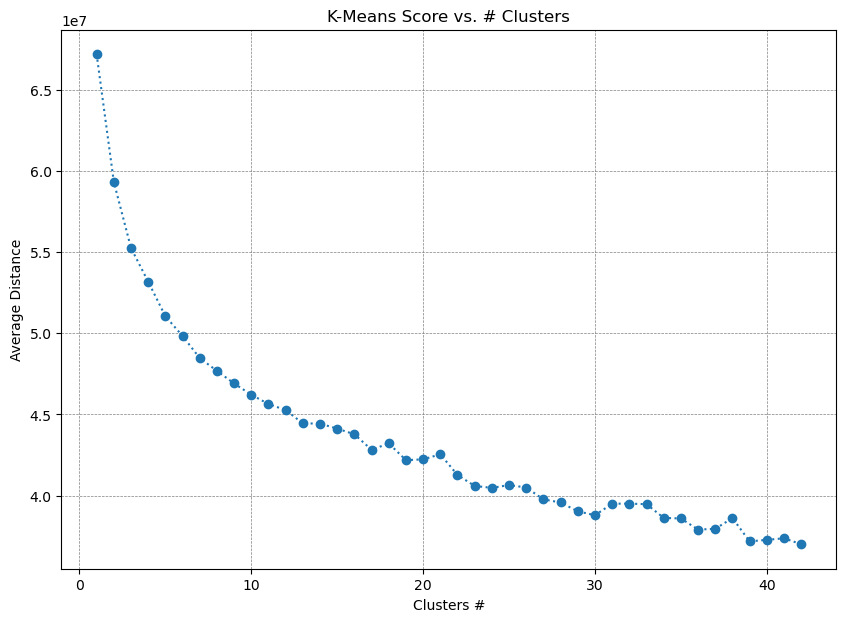

In [100]:
plt.figure(figsize=(10, 7))
plt.plot(clusters_list, avg_dist,  linestyle='dotted', 
         marker='o')

plt.xlabel('Clusters #')
plt.ylabel('Average Distance')
plt.title('K-Means Score vs. # Clusters')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

In [101]:
# Apply K-Means using 10 clusters
model_KMeans = KMeans(n_clusters=10, init='k-means++')
data_predictions = model_KMeans.fit_predict(data_pca)

### Discussion 3.1: Apply Clustering to General Population

We plotted a graph of the Average Distance from Centroids vs. Number of Clusters to determine the optimun number of clusters to group our data. We don't have a clear elbow, but the rate of decay diminishes dramatically after 10 clusters. We decided to fit our model using 10 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [102]:
# Load in the customer demographics data.
data_customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [103]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#Clean Customers data
customers_clean = clean_data(data_customers)

In [104]:
# Add Column GEBAEUDETYP_5.0 with false values to the cleaned customer data
customers_clean.shape

(139800, 112)

In [105]:
tmp_GT5 = pd.DataFrame({'GEBAEUDETYP_5.0': [False] * 139800})

In [106]:
customers_clean.columns.get_loc('GEBAEUDETYP_4.0')

96

In [107]:
customers_clean.insert(97, 'GEBAEUDETYP_5.0', tmp_GT5['GEBAEUDETYP_5.0'])

In [108]:
# Replace nans with our imputer
customers_imputed = imp_mean.transform(customers_clean)

In [109]:
# Scale the customer data
customer_scaled = scaler.transform(customers_imputed)

# Apply PCA to customer data
customer_pca = pca.transform(customer_scaled)

# Group customer data in clusters
customer_predictions = model_KMeans.predict(customer_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

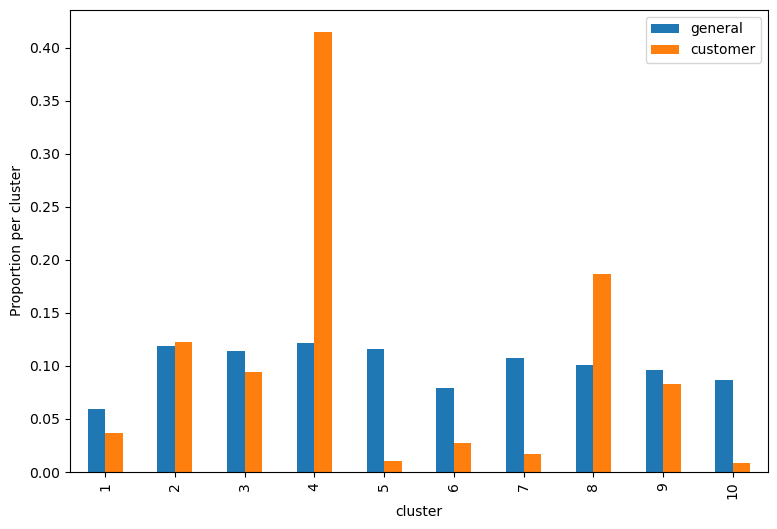

In [110]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

data_prop = []
cust_prop = []

x = range(1, 11)

for i in range(10):
    data_prop.append((data_predictions == i).sum()/len(data_predictions))
    cust_prop.append((customer_predictions == i).sum()/len(customer_predictions))


df_prop = pd.DataFrame({'cluster' : x, 'general' : data_prop, 'customer':cust_prop})

df_prop.plot(x='cluster', y = ['general', 'customer'], kind='bar', figsize=(9,6))
plt.ylabel('Proportion per cluster')
plt.show()

In [112]:
# Function to plot distribution of values inside each cluster

def plot_cluster(data):
    
    weights1 = weights_pca(data_azdias, pca, 1, 3)
    weights2 = weights_pca(data_azdias, pca, 2, 2)
    weights3 = weights_pca(data_azdias, pca, 3, 1)

    
    weights = pd.concat([weights1, weights2, weights3])
    fig, axs = plt.subplots(4,3, figsize=(12, 14))
    i = 0
    j = 0
    for column in weights.transpose():
        sns.countplot(x=data[column], ax = axs[i,j], color='#33A1C9')
        if j == 2:
            i += 1
            j = 0
        else:
            j += 1

    plt.show();
    return weights

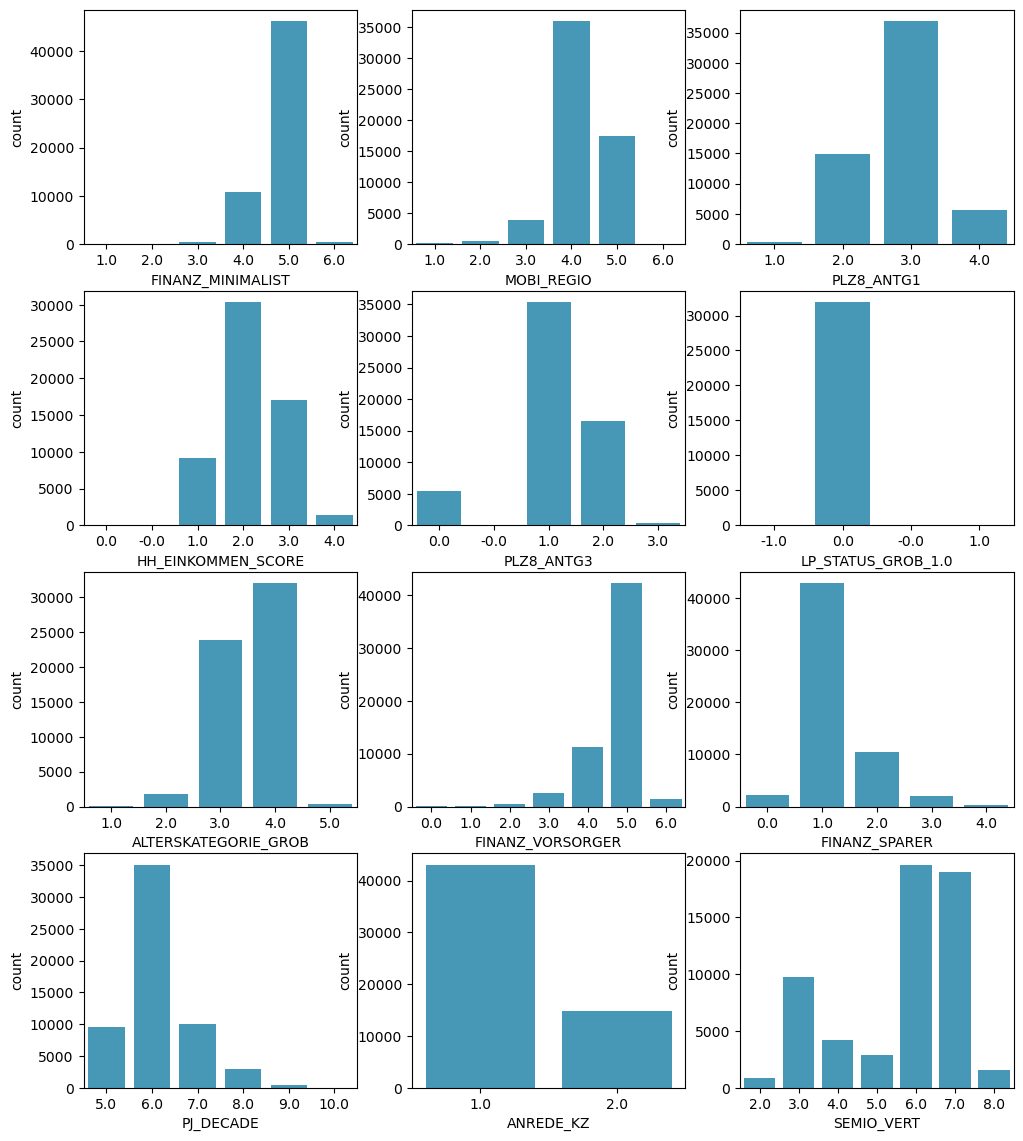

In [115]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

data = scaler.inverse_transform(pca.inverse_transform(customer_pca[np.where(customer_predictions==3)])).round()
df = pd.DataFrame(data=data,
          index=np.array(range(0, data.shape[0])),
          columns=data_azdias.columns)

weights = plot_cluster(df)

**Cluster 9**:

Group characterized by low movement patterns, highest to very high income, money savers, from 30 to 60 years old, and mostly females.

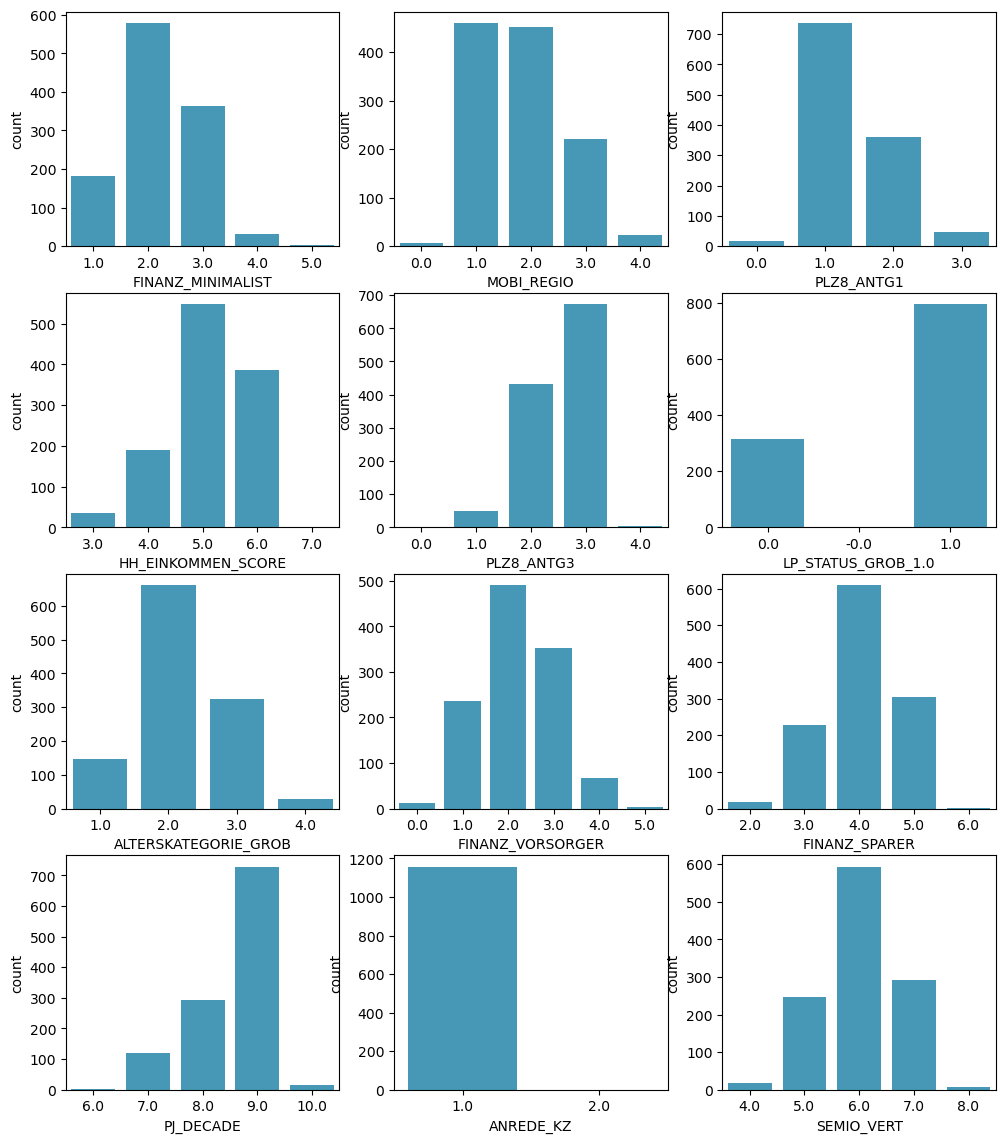

In [116]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
data = scaler.inverse_transform(pca.inverse_transform(customer_pca[np.where(customer_predictions==9)])).round()
df = pd.DataFrame(data=data,
          index=np.array(range(0, data.shape[0])),
          columns=data_azdias.columns)

weights = plot_cluster(df)

Cluster 10:

Group characterized as financial minimalist, with very high to middle movement patterns, living in cells with average to high share of 6-10 family homes. Ages from 30 to 60, with a higher share of people between 30-45 years. Low saving habits, mostly females and dreamers.

### Discussion 3.3: Compare Customer Data to Demographics Data

After analyzing the clusters, we can see 2 groups that overrepresented in the company customer dataset and 3 underrepresented.

Group characterized by low movement patterns, highest to very high income, money savers, from 30 to 60 years old, and mostly females.


The overrepresented group is characterized by females with low movement patterns that live in cells with high share of 1-2 family homes, and from 30 to 60 years. They are more prepared finacially, with high income and good saving habits.

The underrepresented is characterized by females, with high movement patters, living in more dense areas, with a high share of 6-10 family homes. Low saving habits, and ages between 30 to 60 years, but with a higher share of people between 30 to 45.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.